<a href="https://colab.research.google.com/github/aniket-alt/CMPE-258-Deep-Learning/blob/main/Assignment%20-%203/colab_e_tensorflow_variants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab e) 3-Layer Deep Neural Network using TensorFlow (All Variants)

**CMPE 258 - Deep Learning Assignment**

## Objective
Implement a 3-layer deep neural network for non-linear regression using **TensorFlow** with four different approaches:

| Section | Approach | Description |
|---------|----------|-------------|
| **e-i** | From Scratch | No high-level API, manual gradients |
| **e-ii** | Built-in Layers | Using `tf.keras.layers` only |
| **e-iii** | Functional API | Using `tf.keras.Model` with functional API |
| **e-iv** | High-Level Keras | Using `tf.keras.Sequential` |

## Target Function
$$y = \sin(x_1) \cdot \cos(x_2) + x_3^2 + 0.5 \cdot x_1 \cdot x_2$$

## Network Architecture
```
Input (3) → Hidden1 (64, Tanh) → Hidden2 (32, Tanh) → Output (1)
```

## 1. Import Libraries and Setup

We import TensorFlow and its Keras module for neural network building.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.19.0
Keras version: 3.10.0
GPU available: True


## 2. Define Target Function and Generate Data

This is common to all implementations. We generate synthetic data for training and testing.

In [2]:
def target_function(x1, x2, x3):
    """
    Non-linear target function with 3 variables:
    y = sin(x1) * cos(x2) + x3^2 + 0.5 * x1 * x2
    """
    return np.sin(x1) * np.cos(x2) + x3**2 + 0.5 * x1 * x2

def generate_data(n_samples=2000, noise_std=0.05):
    """
    Generate synthetic data for training and testing.
    """
    x1 = np.random.uniform(-2, 2, n_samples)
    x2 = np.random.uniform(-2, 2, n_samples)
    x3 = np.random.uniform(-2, 2, n_samples)

    X = np.column_stack([x1, x2, x3]).astype(np.float32)
    y = target_function(x1, x2, x3) + np.random.normal(0, noise_std, n_samples)
    y = y.reshape(-1, 1).astype(np.float32)

    return X, y

# Generate data
X_train, y_train = generate_data(n_samples=2000)
X_test, y_test = generate_data(n_samples=500)

print(f"Training data: X={X_train.shape}, y={y_train.shape}")
print(f"Test data: X={X_test.shape}, y={y_test.shape}")

Training data: X=(2000, 3), y=(2000, 1)
Test data: X=(500, 3), y=(500, 1)


## 3. Utility Functions for Evaluation and Visualization

These functions will be used to evaluate and visualize all implementations.

In [3]:
def evaluate_model_generic(y_pred, y_test, title="Model"):
    """
    Evaluate model performance with metrics and scatter plot.
    """
    y_pred = y_pred.flatten()
    y_test_flat = y_test.flatten()

    mse = np.mean((y_pred - y_test_flat)**2)
    mae = np.mean(np.abs(y_pred - y_test_flat))
    rmse = np.sqrt(mse)

    ss_res = np.sum((y_test_flat - y_pred)**2)
    ss_tot = np.sum((y_test_flat - np.mean(y_test_flat))**2)
    r2 = 1 - (ss_res / ss_tot)

    print(f"\n{title} - Evaluation Metrics:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.6f}")

    return mse, r2

def plot_loss_curves(train_losses, test_losses, title="Training Progress"):
    """
    Plot training and test loss curves.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.plot(test_losses, label='Test Loss', color='red', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

---
# Section e-i: TensorFlow from Scratch (No High-Level API)
---

In this implementation, we:
- Manually create weight and bias variables with `tf.Variable`
- Implement forward pass using basic TensorFlow operations
- Use `tf.GradientTape` for automatic differentiation
- Manually update parameters

**NO** `keras.layers`, `keras.Model`, or `keras.Sequential` used.

In [4]:
print("="*70)
print("SECTION e-i: TensorFlow from Scratch (No High-Level API)")
print("="*70)

SECTION e-i: TensorFlow from Scratch (No High-Level API)


### e-i.1: Initialize Parameters Manually

We create weight and bias tensors using `tf.Variable` with Xavier initialization.

In [5]:
class NeuralNetworkScratch:
    """
    3-Layer Neural Network implemented from scratch using TensorFlow.
    No keras.layers, keras.Model, or keras.Sequential used.
    """

    def __init__(self, input_size=3, hidden1_size=64, hidden2_size=32, output_size=1):
        """
        Initialize weights and biases manually.
        Uses Xavier initialization for better convergence.
        """
        # Layer 1: Input -> Hidden1
        self.W1 = tf.Variable(
            tf.random.normal([input_size, hidden1_size]) * np.sqrt(2.0 / (input_size + hidden1_size)),
            name='W1', dtype=tf.float32
        )
        self.b1 = tf.Variable(tf.zeros([1, hidden1_size]), name='b1', dtype=tf.float32)

        # Layer 2: Hidden1 -> Hidden2
        self.W2 = tf.Variable(
            tf.random.normal([hidden1_size, hidden2_size]) * np.sqrt(2.0 / (hidden1_size + hidden2_size)),
            name='W2', dtype=tf.float32
        )
        self.b2 = tf.Variable(tf.zeros([1, hidden2_size]), name='b2', dtype=tf.float32)

        # Layer 3: Hidden2 -> Output
        self.W3 = tf.Variable(
            tf.random.normal([hidden2_size, output_size]) * np.sqrt(2.0 / (hidden2_size + output_size)),
            name='W3', dtype=tf.float32
        )
        self.b3 = tf.Variable(tf.zeros([1, output_size]), name='b3', dtype=tf.float32)

        # Store all trainable variables
        self.trainable_variables = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]

        print("Network Initialized (From Scratch):")
        print(f"  W1: {self.W1.shape}, b1: {self.b1.shape}")
        print(f"  W2: {self.W2.shape}, b2: {self.b2.shape}")
        print(f"  W3: {self.W3.shape}, b3: {self.b3.shape}")

    def forward(self, X):
        """
        Forward pass using basic TensorFlow operations.
        """
        # Layer 1: Linear + Tanh
        z1 = tf.matmul(X, self.W1) + self.b1
        a1 = tf.nn.tanh(z1)

        # Layer 2: Linear + Tanh
        z2 = tf.matmul(a1, self.W2) + self.b2
        a2 = tf.nn.tanh(z2)

        # Layer 3: Linear output
        z3 = tf.matmul(a2, self.W3) + self.b3

        return z3

    def __call__(self, X):
        return self.forward(X)

# Create model
model_scratch = NeuralNetworkScratch()

Network Initialized (From Scratch):
  W1: (3, 64), b1: (1, 64)
  W2: (64, 32), b2: (1, 32)
  W3: (32, 1), b3: (1, 1)


### e-i.2: Training Loop with GradientTape

We use `tf.GradientTape` to record operations for automatic differentiation, then manually apply gradients.


Training for 500 epochs with learning rate 0.05
Epoch   1/500 | Train Loss: 4.058193 | Test Loss: 2.727779
Epoch  50/500 | Train Loss: 1.628926 | Test Loss: 1.655654
Epoch 100/500 | Train Loss: 1.411490 | Test Loss: 1.430328
Epoch 150/500 | Train Loss: 0.502660 | Test Loss: 0.502917
Epoch 200/500 | Train Loss: 0.170251 | Test Loss: 0.168058
Epoch 250/500 | Train Loss: 0.099784 | Test Loss: 0.095331
Epoch 300/500 | Train Loss: 0.092706 | Test Loss: 0.089480
Epoch 350/500 | Train Loss: 0.063416 | Test Loss: 0.059378
Epoch 400/500 | Train Loss: 0.121081 | Test Loss: 0.156756
Epoch 450/500 | Train Loss: 0.048062 | Test Loss: 0.044421
Epoch 500/500 | Train Loss: 0.038070 | Test Loss: 0.034456

e-i: TensorFlow From Scratch - Evaluation Metrics:
  MSE:  0.034456
  RMSE: 0.185624
  MAE:  0.139610
  R²:   0.983618


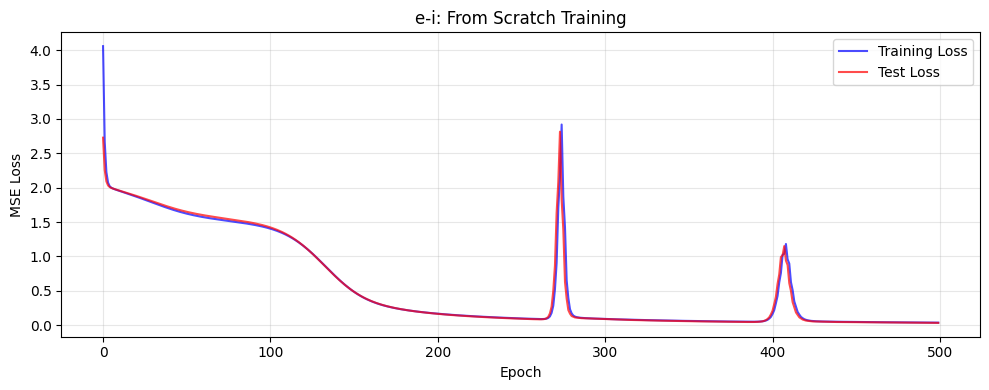

In [6]:
def train_scratch(model, X_train, y_train, X_test, y_test,
                  epochs=500, learning_rate=0.01, print_every=50):
    """
    Train the from-scratch model using GradientTape.
    """
    train_losses = []
    test_losses = []

    print(f"\nTraining for {epochs} epochs with learning rate {learning_rate}")

    for epoch in range(epochs):
        # Use GradientTape for automatic differentiation
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = model(X_train)

            # Compute MSE loss manually
            loss = tf.reduce_mean(tf.square(y_pred - y_train))

        # Compute gradients
        gradients = tape.gradient(loss, model.trainable_variables)

        # Manual gradient descent update
        for var, grad in zip(model.trainable_variables, gradients):
            var.assign_sub(learning_rate * grad)

        train_losses.append(loss.numpy())

        # Compute test loss
        y_pred_test = model(X_test)
        test_loss = tf.reduce_mean(tf.square(y_pred_test - y_test))
        test_losses.append(test_loss.numpy())

        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {loss.numpy():.6f} | Test Loss: {test_loss.numpy():.6f}")

    return train_losses, test_losses

# Train the model
train_losses_scratch, test_losses_scratch = train_scratch(
    model_scratch, X_train, y_train, X_test, y_test,
    epochs=500, learning_rate=0.05, print_every=50
)

# Evaluate and plot
y_pred_scratch = model_scratch(X_test).numpy()
evaluate_model_generic(y_pred_scratch, y_test, "e-i: TensorFlow From Scratch")
plot_loss_curves(train_losses_scratch, test_losses_scratch, "e-i: From Scratch Training")

---
# Section e-ii: TensorFlow with Built-in Layers Only
---

In this implementation, we:
- Use `tf.keras.layers.Dense` for layer creation
- Manually create a list of layers (NOT using Sequential or Model subclassing)
- Write a custom training loop

This shows intermediate usage of Keras layers without full model abstraction.

In [7]:
print("\n" + "="*70)
print("SECTION e-ii: TensorFlow with Built-in Layers Only")
print("="*70)


SECTION e-ii: TensorFlow with Built-in Layers Only


### e-ii.1: Create Layers and Forward Function

We use `layers.Dense` but manage them manually without Sequential or Model.

In [9]:
# Create layers (built-in, but managed manually)
layer1 = layers.Dense(64, activation='tanh', name='hidden1')
layer2 = layers.Dense(32, activation='tanh', name='hidden2')
layer3 = layers.Dense(1, activation=None, name='output')  # Linear output

# Build layers by calling them once
_ = layer1(X_train[:1])
_ = layer2(layer1(X_train[:1]))
_ = layer3(layer2(layer1(X_train[:1])))

# Collect all trainable variables
all_layers = [layer1, layer2, layer3]
trainable_vars = []
for layer in all_layers:
    trainable_vars.extend(layer.trainable_variables)

print("Built-in Layers Created:")
for layer in all_layers:
    print(f"  {layer.name}: units={layer.units}")
print(f"\nTotal trainable variables: {len(trainable_vars)}")

def forward_layers(X):
    """
    Forward pass through manually managed layers.
    """
    x = layer1(X)
    x = layer2(x)
    x = layer3(x)
    return x

Built-in Layers Created:
  hidden1: units=64
  hidden2: units=32
  output: units=1

Total trainable variables: 6


### e-ii.2: Training with Custom Loop

We use GradientTape with the built-in layers.


Training for 300 epochs with Adam optimizer
Epoch   1/300 | Train Loss: 4.464963 | Test Loss: 3.421181
Epoch  30/300 | Train Loss: 1.606632 | Test Loss: 1.627406
Epoch  60/300 | Train Loss: 0.966190 | Test Loss: 0.966444
Epoch  90/300 | Train Loss: 0.077506 | Test Loss: 0.070781
Epoch 120/300 | Train Loss: 0.026944 | Test Loss: 0.022905
Epoch 150/300 | Train Loss: 0.011497 | Test Loss: 0.010166
Epoch 180/300 | Train Loss: 0.009051 | Test Loss: 0.007682
Epoch 210/300 | Train Loss: 0.005859 | Test Loss: 0.005695
Epoch 240/300 | Train Loss: 0.005107 | Test Loss: 0.005065
Epoch 270/300 | Train Loss: 0.008774 | Test Loss: 0.007480
Epoch 300/300 | Train Loss: 0.004647 | Test Loss: 0.004517

e-ii: Built-in Layers Only - Evaluation Metrics:
  MSE:  0.004517
  RMSE: 0.067208
  MAE:  0.052076
  R²:   0.997852


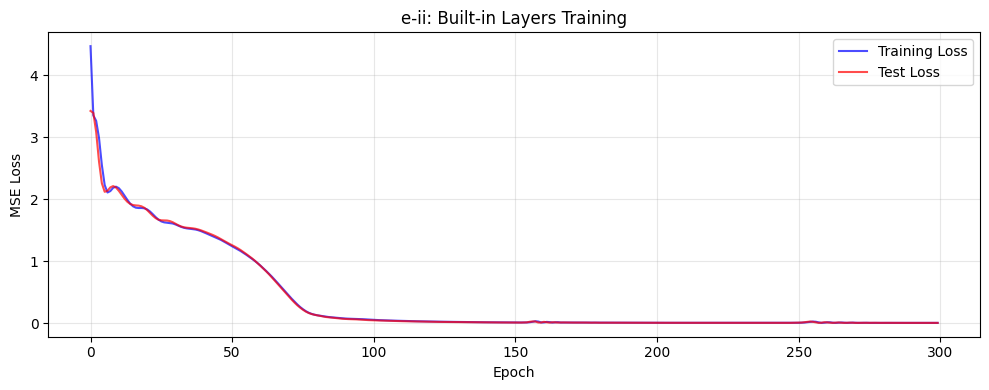

In [10]:
def train_builtin_layers(X_train, y_train, X_test, y_test,
                         epochs=300, learning_rate=0.001, print_every=30):
    """
    Train using built-in layers with custom loop.
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    train_losses = []
    test_losses = []

    print(f"\nTraining for {epochs} epochs with Adam optimizer")

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            y_pred = forward_layers(X_train)
            loss = tf.reduce_mean(tf.square(y_pred - y_train))

        # Compute and apply gradients using optimizer
        gradients = tape.gradient(loss, trainable_vars)
        optimizer.apply_gradients(zip(gradients, trainable_vars))

        train_losses.append(loss.numpy())

        # Test loss
        y_pred_test = forward_layers(X_test)
        test_loss = tf.reduce_mean(tf.square(y_pred_test - y_test))
        test_losses.append(test_loss.numpy())

        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {loss.numpy():.6f} | Test Loss: {test_loss.numpy():.6f}")

    return train_losses, test_losses

# Train
train_losses_layers, test_losses_layers = train_builtin_layers(
    X_train, y_train, X_test, y_test,
    epochs=300, learning_rate=0.01, print_every=30
)

# Evaluate and plot
y_pred_layers = forward_layers(X_test).numpy()
evaluate_model_generic(y_pred_layers, y_test, "e-ii: Built-in Layers Only")
plot_loss_curves(train_losses_layers, test_losses_layers, "e-ii: Built-in Layers Training")

---
# Section e-iii: TensorFlow Functional API
---

The Functional API allows building more complex models with:
- Multiple inputs/outputs
- Shared layers
- Non-linear topology (skip connections, etc.)

We define the model by specifying input/output tensors and creating a `Model` object.

In [11]:
print("\n" + "="*70)
print("SECTION e-iii: TensorFlow Functional API")
print("="*70)


SECTION e-iii: TensorFlow Functional API


### e-iii.1: Build Model with Functional API

We define inputs, chain layers functionally, and create a Model.

In [12]:
def build_functional_model(input_size=3, hidden1_size=64, hidden2_size=32, output_size=1):
    """
    Build neural network using Keras Functional API.

    The Functional API allows more flexibility than Sequential:
    - Multiple inputs/outputs
    - Shared layers
    - Non-linear topology
    """
    # Define input layer
    inputs = keras.Input(shape=(input_size,), name='input')

    # Define hidden layers functionally
    x = layers.Dense(hidden1_size, activation='tanh', name='hidden1')(inputs)
    x = layers.Dense(hidden2_size, activation='tanh', name='hidden2')(x)

    # Define output layer
    outputs = layers.Dense(output_size, activation=None, name='output')(x)

    # Create Model by specifying inputs and outputs
    model = Model(inputs=inputs, outputs=outputs, name='functional_nn')

    return model

# Build model
model_functional = build_functional_model()

# Display model summary
print("\nFunctional API Model Summary:")
model_functional.summary()


Functional API Model Summary:


Model: "functional_nn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,369 (9.25 KB)

 Trainable params: 2,369 (9.25 KB)

 Non-trainable params: 0 (0.00 B)

### e-iii.2: Compile and Train

We use Keras `compile()` and `fit()` methods for training.


Training Functional API Model...
Final Train Loss: 0.006957
Final Val Loss: 0.007638

e-iii: Functional API - Evaluation Metrics:
  MSE:  0.007638
  RMSE: 0.087398
  MAE:  0.069976
  R²:   0.996368


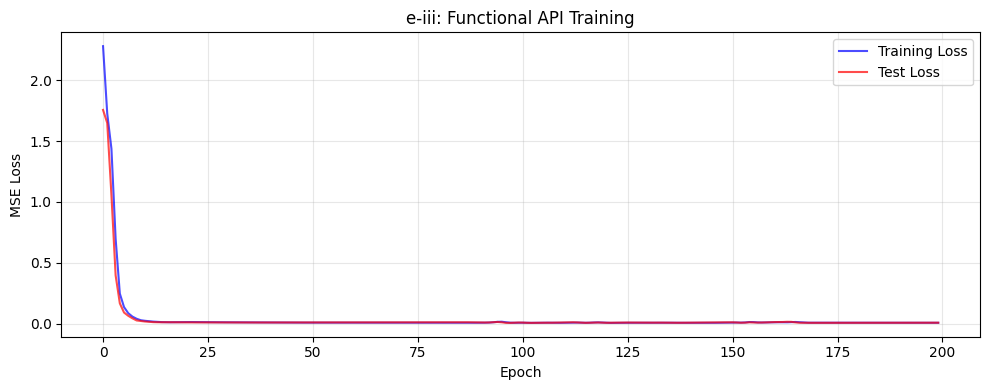

In [13]:
# Compile model
model_functional.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=MeanSquaredError(),
    metrics=['mae']
)

# Train model
print("\nTraining Functional API Model...")
history_functional = model_functional.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=64,
    verbose=0  # Silent training
)

# Print final results
print(f"Final Train Loss: {history_functional.history['loss'][-1]:.6f}")
print(f"Final Val Loss: {history_functional.history['val_loss'][-1]:.6f}")

# Evaluate and plot
y_pred_functional = model_functional.predict(X_test, verbose=0)
evaluate_model_generic(y_pred_functional, y_test, "e-iii: Functional API")
plot_loss_curves(history_functional.history['loss'],
                 history_functional.history['val_loss'],
                 "e-iii: Functional API Training")

---
# Section e-iv: TensorFlow High-Level Keras (Sequential API)
---

The Sequential API is the simplest way to build neural networks in Keras:
- Stack layers linearly
- Automatic input shape inference
- Clean, minimal code

Best for simple feed-forward networks without branching.

In [14]:
print("\n" + "="*70)
print("SECTION e-iv: TensorFlow High-Level Keras (Sequential API)")
print("="*70)


SECTION e-iv: TensorFlow High-Level Keras (Sequential API)


### e-iv.1: Build Model with Sequential API

The Sequential API allows stacking layers in a simple list.

In [15]:
def build_sequential_model(input_size=3, hidden1_size=64, hidden2_size=32, output_size=1):
    """
    Build neural network using Keras Sequential API.

    This is the simplest and most concise way to build
    feed-forward neural networks in Keras.
    """
    model = Sequential([
        # Input layer (specify input shape)
        layers.Input(shape=(input_size,)),

        # Hidden layer 1
        layers.Dense(hidden1_size, activation='tanh', name='hidden1'),

        # Hidden layer 2
        layers.Dense(hidden2_size, activation='tanh', name='hidden2'),

        # Output layer
        layers.Dense(output_size, name='output')
    ], name='sequential_nn')

    return model

# Build model
model_sequential = build_sequential_model()

# Display model summary
print("\nSequential API Model Summary:")
model_sequential.summary()


Sequential API Model Summary:


Model: "sequential_nn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,369 (9.25 KB)

 Trainable params: 2,369 (9.25 KB)

 Non-trainable params: 0 (0.00 B)

### e-iv.2: Compile and Train with Callbacks

We use callbacks for early stopping and learning rate reduction.


Training Sequential API Model...

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 68: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 89: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 100: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 110: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 120: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
Epoch 120: early stopping
Restoring model weights from the end of the best epoch: 100.

Final Train Loss: 0.002950
Final Val Loss: 0.003438
Epochs trained: 120

e-iv: Sequential API - Evaluation Metrics:
  MSE:  0.003363
  RMSE: 0.057993
  MAE:  0.046869
  R²:   0.998401


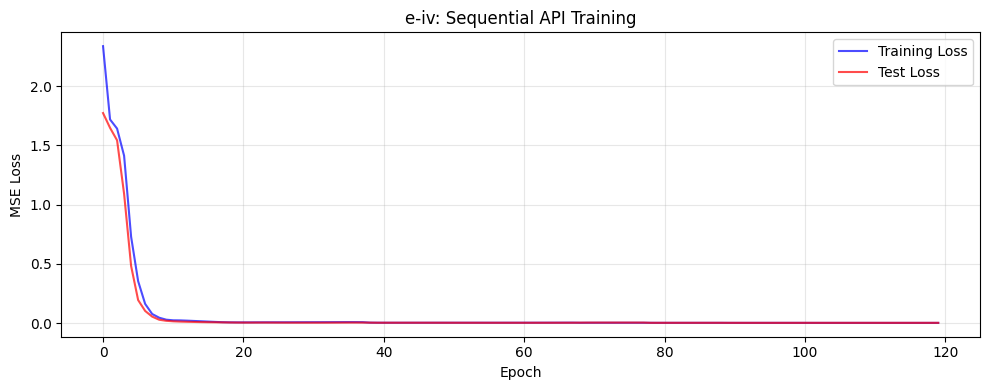

In [16]:
# Compile model
model_sequential.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1
)

# Train model
print("\nTraining Sequential API Model...")
history_sequential = model_sequential.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=0  # Silent training
)

# Print final results
print(f"\nFinal Train Loss: {history_sequential.history['loss'][-1]:.6f}")
print(f"Final Val Loss: {history_sequential.history['val_loss'][-1]:.6f}")
print(f"Epochs trained: {len(history_sequential.history['loss'])}")

# Evaluate and plot
y_pred_sequential = model_sequential.predict(X_test, verbose=0)
evaluate_model_generic(y_pred_sequential, y_test, "e-iv: Sequential API")
plot_loss_curves(history_sequential.history['loss'],
                 history_sequential.history['val_loss'],
                 "e-iv: Sequential API Training")

---
# Comparison of All TensorFlow Implementations
---

Let's compare the performance and characteristics of all four implementations.


COMPARISON OF ALL TENSORFLOW IMPLEMENTATIONS

Implementation                 Train Loss       Test Loss
-------------------------------------------------------
e-i: From Scratch                0.038070        0.034456
e-ii: Built-in Layers            0.004647        0.004517
e-iii: Functional API            0.006957        0.007638
e-iv: Sequential API             0.002950        0.003438


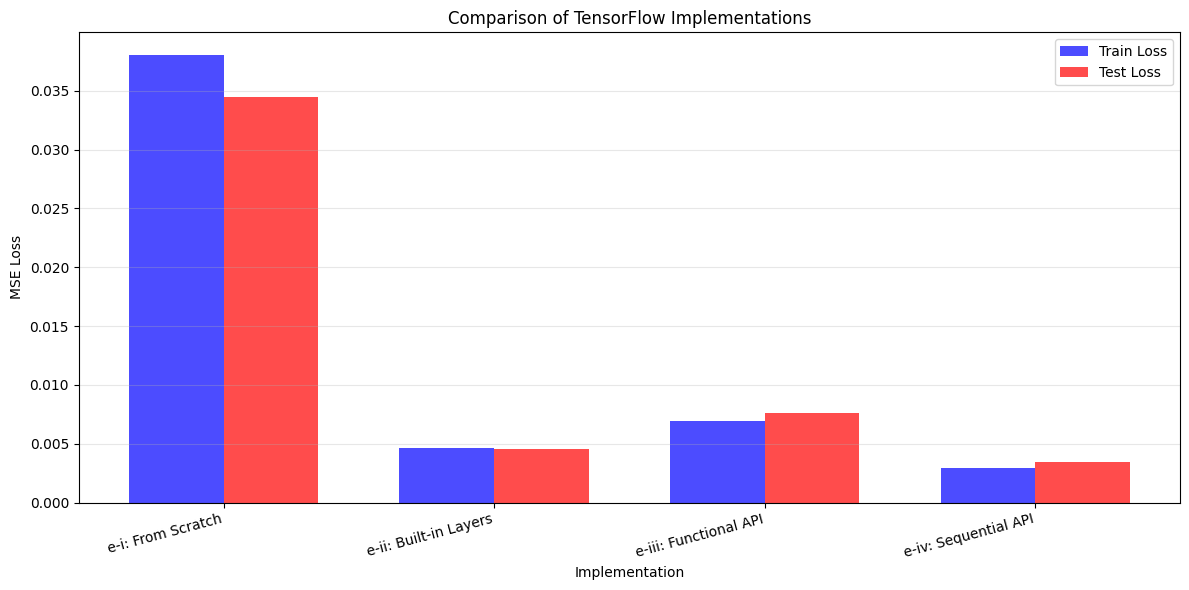

In [17]:
print("\n" + "="*70)
print("COMPARISON OF ALL TENSORFLOW IMPLEMENTATIONS")
print("="*70)

# Collect final losses
results = {
    'e-i: From Scratch': {
        'train_loss': train_losses_scratch[-1],
        'test_loss': test_losses_scratch[-1]
    },
    'e-ii: Built-in Layers': {
        'train_loss': train_losses_layers[-1],
        'test_loss': test_losses_layers[-1]
    },
    'e-iii: Functional API': {
        'train_loss': history_functional.history['loss'][-1],
        'test_loss': history_functional.history['val_loss'][-1]
    },
    'e-iv: Sequential API': {
        'train_loss': history_sequential.history['loss'][-1],
        'test_loss': history_sequential.history['val_loss'][-1]
    }
}

print("\n{:<25} {:>15} {:>15}".format("Implementation", "Train Loss", "Test Loss"))
print("-" * 55)
for name, losses in results.items():
    print("{:<25} {:>15.6f} {:>15.6f}".format(name, losses['train_loss'], losses['test_loss']))

# Bar chart comparison
fig, ax = plt.subplots(figsize=(12, 6))

implementations = list(results.keys())
train_losses_all = [results[k]['train_loss'] for k in implementations]
test_losses_all = [results[k]['test_loss'] for k in implementations]

x = np.arange(len(implementations))
width = 0.35

bars1 = ax.bar(x - width/2, train_losses_all, width, label='Train Loss', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, test_losses_all, width, label='Test Loss', color='red', alpha=0.7)

ax.set_xlabel('Implementation')
ax.set_ylabel('MSE Loss')
ax.set_title('Comparison of TensorFlow Implementations')
ax.set_xticks(x)
ax.set_xticklabels(implementations, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 4D Visualization (Final Model)

Let's create a 4D visualization using the best performing model.

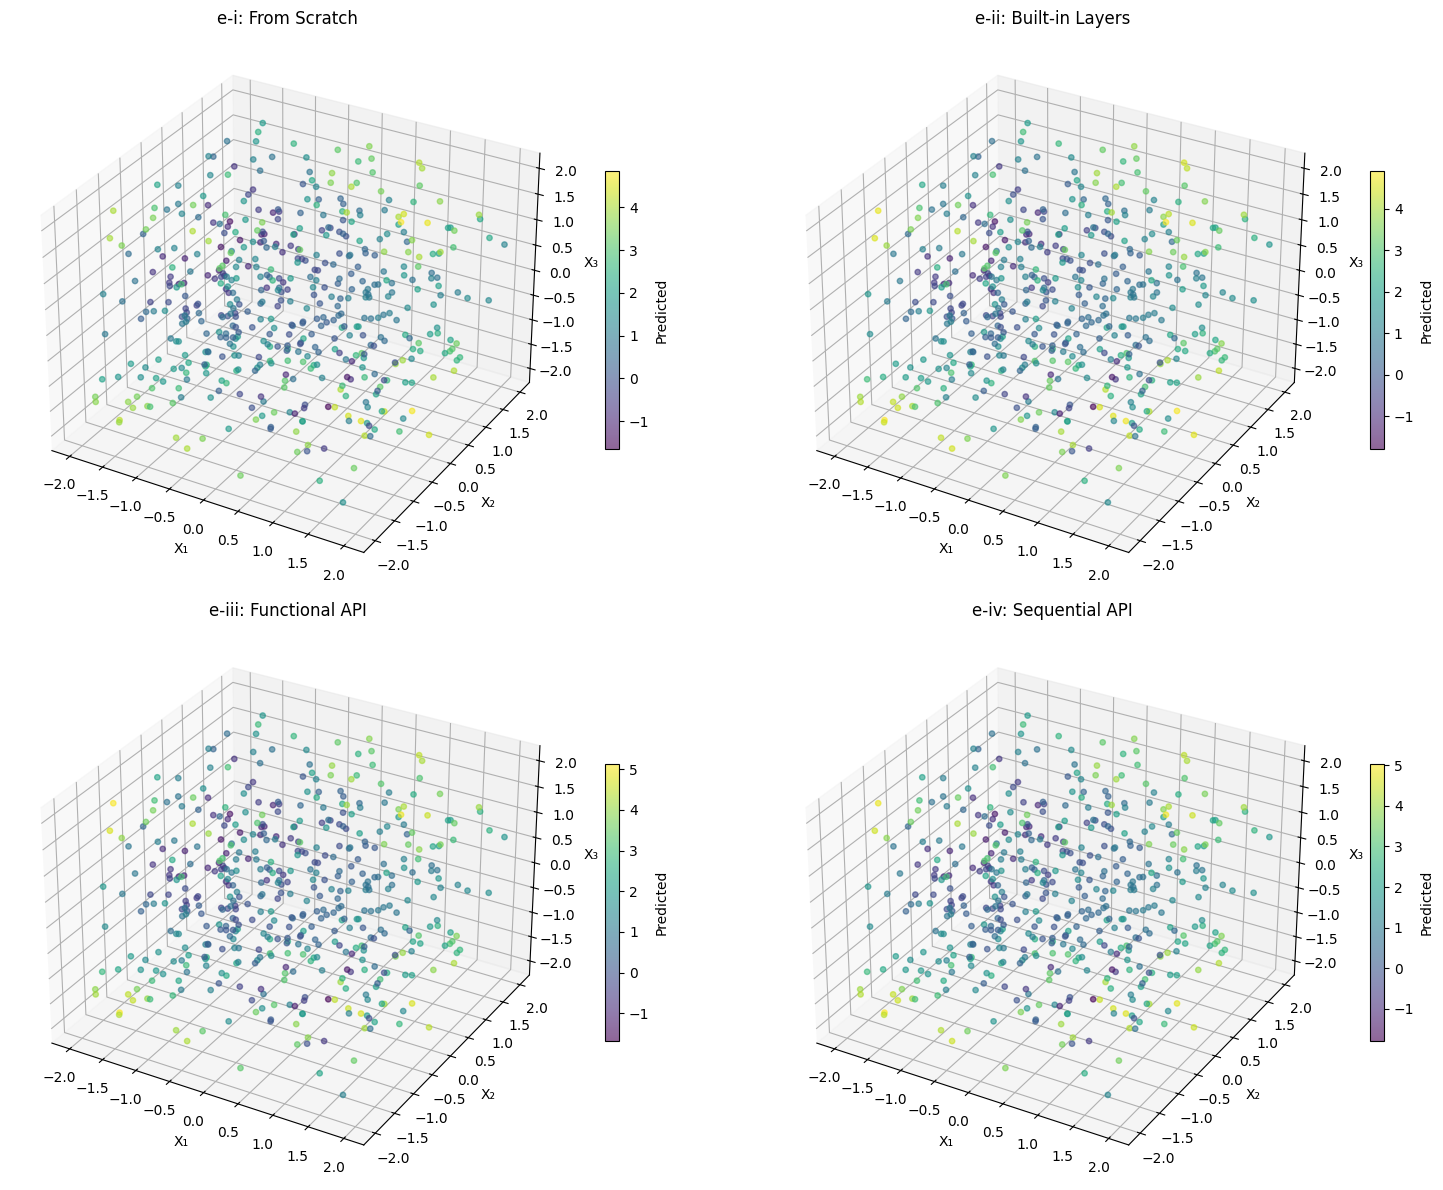

In [18]:
def plot_4d_comparison(X_test, y_test, predictions_dict):
    """
    Create 4D visualizations comparing all implementations.
    """
    fig = plt.figure(figsize=(16, 12))
    y_actual = y_test.flatten()

    for idx, (name, y_pred) in enumerate(predictions_dict.items(), 1):
        ax = fig.add_subplot(2, 2, idx, projection='3d')
        y_pred_flat = y_pred.flatten()

        scatter = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2],
                            c=y_pred_flat, cmap='viridis', alpha=0.6, s=15)
        ax.set_xlabel('X₁')
        ax.set_ylabel('X₂')
        ax.set_zlabel('X₃')
        ax.set_title(name)
        plt.colorbar(scatter, ax=ax, shrink=0.5, label='Predicted')

    plt.tight_layout()
    plt.savefig('4d_visualization_tensorflow.png', dpi=150, bbox_inches='tight')
    plt.show()

# Collect all predictions
predictions = {
    'e-i: From Scratch': y_pred_scratch,
    'e-ii: Built-in Layers': y_pred_layers,
    'e-iii: Functional API': y_pred_functional,
    'e-iv: Sequential API': y_pred_sequential
}

plot_4d_comparison(X_test, y_test, predictions)

## Summary and Key Takeaways

### Comparison of TensorFlow Approaches:

| Approach | Complexity | Flexibility | Best Use Case |
|----------|------------|-------------|---------------|
| **e-i: From Scratch** | High | Maximum | Learning fundamentals |
| **e-ii: Built-in Layers** | Medium | High | Custom training loops |
| **e-iii: Functional API** | Medium | High | Complex architectures |
| **e-iv: Sequential API** | Low | Low | Simple feed-forward nets |

### Key TensorFlow Components:

| Component | Used In | Purpose |
|-----------|---------|----------|
| `tf.Variable` | e-i | Manual parameter creation |
| `tf.GradientTape` | e-i, e-ii | Automatic differentiation |
| `layers.Dense` | e-ii, e-iii, e-iv | Fully connected layer |
| `keras.Input` | e-iii | Define input tensor |
| `keras.Model` | e-iii | Functional model |
| `keras.Sequential` | e-iv | Sequential model |

In [19]:
# Final summary
print("="*70)
print("COLAB E - TENSORFLOW VARIANTS IMPLEMENTATION SUMMARY")
print("="*70)
print(f"\nTarget Function: y = sin(x₁)·cos(x₂) + x₃² + 0.5·x₁·x₂")
print(f"Architecture: 3 → 64 (Tanh) → 32 (Tanh) → 1 (Linear)")
print(f"\nTraining Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")

print("\n" + "-"*70)
print("Implementation Results:")
print("-"*70)
for name, losses in results.items():
    print(f"  {name}:")
    print(f"    Final Test Loss: {losses['test_loss']:.6f}")

print("\n" + "-"*70)
print("TensorFlow Components Used:")
print("-"*70)
print("  e-i:   ✓ tf.Variable, tf.GradientTape, tf.matmul, tf.nn.tanh")
print("  e-ii:  ✓ layers.Dense, tf.GradientTape, optimizer.apply_gradients")
print("  e-iii: ✓ keras.Input, layers.Dense, keras.Model, model.fit()")
print("  e-iv:  ✓ keras.Sequential, layers.Dense, callbacks")
print("="*70)

COLAB E - TENSORFLOW VARIANTS IMPLEMENTATION SUMMARY

Target Function: y = sin(x₁)·cos(x₂) + x₃² + 0.5·x₁·x₂
Architecture: 3 → 64 (Tanh) → 32 (Tanh) → 1 (Linear)

Training Samples: 2000
Test Samples: 500

----------------------------------------------------------------------
Implementation Results:
----------------------------------------------------------------------
  e-i: From Scratch:
    Final Test Loss: 0.034456
  e-ii: Built-in Layers:
    Final Test Loss: 0.004517
  e-iii: Functional API:
    Final Test Loss: 0.007638
  e-iv: Sequential API:
    Final Test Loss: 0.003438

----------------------------------------------------------------------
TensorFlow Components Used:
----------------------------------------------------------------------
  e-i:   ✓ tf.Variable, tf.GradientTape, tf.matmul, tf.nn.tanh
  e-ii:  ✓ layers.Dense, tf.GradientTape, optimizer.apply_gradients
  e-iii: ✓ keras.Input, layers.Dense, keras.Model, model.fit()
  e-iv:  ✓ keras.Sequential, layers.Dense, callba